# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [2]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-11 07:47:24--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-12-11 07:47:24--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [12]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -INCLUDE:?warp_size@cuda@at@@YAHXZ in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using link on your binary to see if there is a dependency on *_cuda.dll library.

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [6]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            # x_gpu = x.to(device)
            # y_gpu = y.to(device)
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("epoch %d Average loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (epoch+1, ave_loss, train_accuracy, val_accuracy))
        if train_accuracy < 0.5:
            return loss_history, train_history, val_history
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        # x_gpu = x.to(device)
        # y_gpu = y.to(device)
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

In [20]:
len(train_loader)*64,len(data_train)

(58624, 73257)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [22]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data/',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

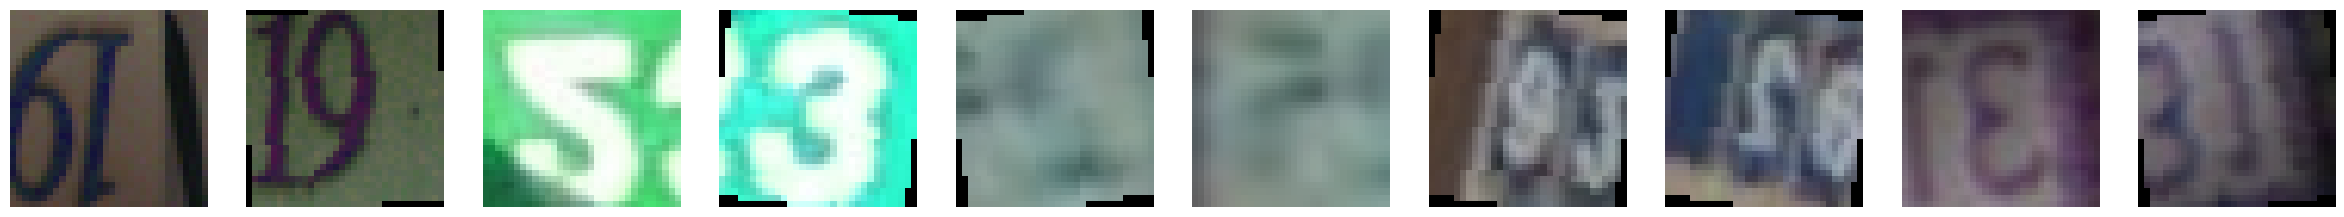

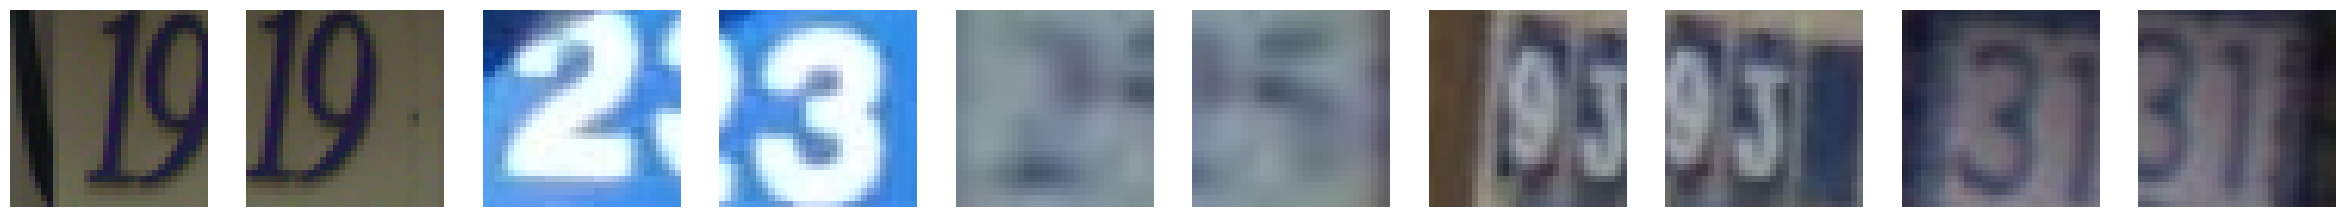

In [24]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10)
])

data_aug_vis = dset.SVHN('./data/',
                       transform=tfs
                      )
data_vis = dset.SVHN('./data/')

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')
  
plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(data_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

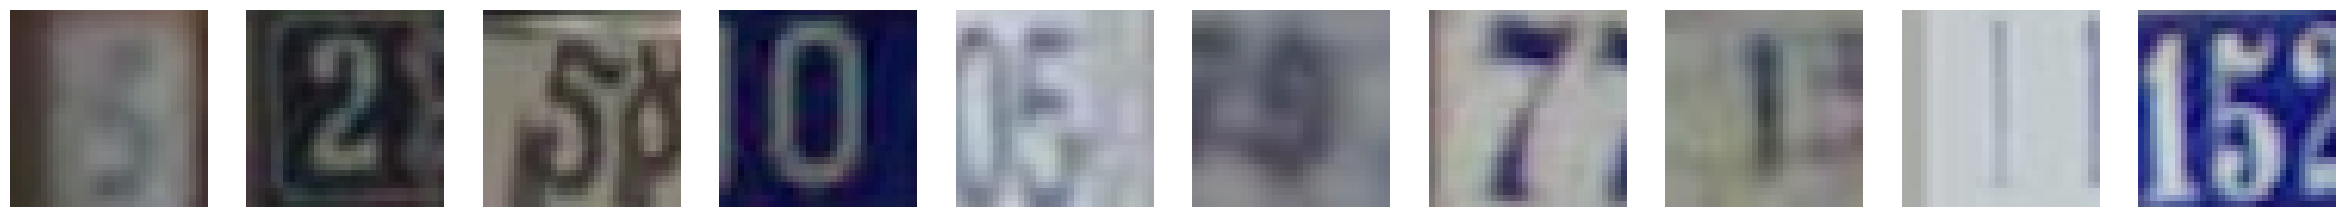

In [26]:
def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(30, 3))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

data_vis = dset.SVHN('./data/')
indices_vis = list(range(data_vis.data.shape[0]))
np.random.shuffle(indices_vis)
visualize_images(indices_vis, data_vis)

TypeError: img should be Tensor Image. Got <class 'PIL.Image.Image'>

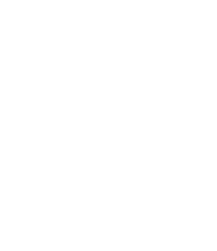

In [27]:
data_vis = dset.SVHN('./data/', transform=transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]))
indices_vis = list(range(data_vis.data.shape[0]))
np.random.shuffle(indices_vis)
visualize_images(indices_vis, data_vis)

In [7]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data/',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.712452, Train accuracy: 0.779886, Val accuracy: 0.831138
Average loss: 0.637586, Train accuracy: 0.805293, Val accuracy: 0.832708
Average loss: 0.615565, Train accuracy: 0.812357, Val accuracy: 0.844857
Average loss: 0.597293, Train accuracy: 0.817084, Val accuracy: 0.850522
Average loss: 0.576502, Train accuracy: 0.823585, Val accuracy: 0.843833


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [35]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
          nn.Conv2d(3, 6, 5, padding=0),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Conv2d(6, 16, 5, padding=0),
          nn.Tanh(),          
          nn.MaxPool2d(2),    
          Flattener(),
          nn.Linear(16*5*5, 120),
          nn.Tanh(),
          nn.Linear(120, 84),
          nn.Tanh(),
          nn.Linear(84, 10)
          )

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [31]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

TypeError: train_model() missing 1 required positional argument: 'num_epochs'

# Подбор гиперпараметров

In [47]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'gamma', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

run_record = {}
epoch_num = 10
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
for i in range(10):

    lenet_model = nn.Sequential(
          nn.Conv2d(3, 6, 5, padding=0),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Conv2d(6, 16, 5, padding=0),
          nn.Tanh(),
          nn.MaxPool2d(2),
          Flattener(),
          nn.Linear(16*5*5, 120),
          nn.Tanh(),
          nn.Linear(120, 84),
          nn.Tanh(),
          nn.Linear(84, 10)
          )

    lr = 10**np.random.uniform(-4, 0)
    gamma = np.random.uniform(0.98, 0.999)
    reg = 10**np.random.uniform(-7, -3)
    print("learning_rate =", lr, "learning_rate_decay =", gamma, "reg =", reg)

    optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, scheduler, epoch_num)
    hp = Hyperparams(learning_rate=lr, gamma=gamma, reg=reg)
    rr = RunResult(model = lenet_model, train_history = train_history, val_history=val_history, final_val_accuracy=val_history[-1])
    run_record[hp] = rr
    # Record all the runs here
    # Key should be Hyperparams and values should be RunResult

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

learning_rate = 0.1562005962716187 learning_rate_decay = 0.9987169790723056 reg = 0.0009779596291785856


C:\Users\lavre\Desktop\dlcourse_ai\venv\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 1 Average loss: 1.065890, Train accuracy: 0.649336, val accuracy: 0.820900
epoch 2 Average loss: 0.560287, Train accuracy: 0.826775, val accuracy: 0.861784
epoch 3 Average loss: 0.487970, Train accuracy: 0.849589, val accuracy: 0.861102
epoch 4 Average loss: 0.447316, Train accuracy: 0.861925, val accuracy: 0.872568
epoch 5 Average loss: 0.425280, Train accuracy: 0.866857, val accuracy: 0.877210
epoch 6 Average loss: 0.402486, Train accuracy: 0.875883, val accuracy: 0.880622
epoch 7 Average loss: 0.391930, Train accuracy: 0.879244, val accuracy: 0.873934
epoch 8 Average loss: 0.379000, Train accuracy: 0.882162, val accuracy: 0.884718
epoch 9 Average loss: 0.365278, Train accuracy: 0.886769, val accuracy: 0.888472
epoch 10 Average loss: 0.367647, Train accuracy: 0.886053, val accuracy: 0.883011
learning_rate = 0.026014837397846918 learning_rate_decay = 0.9974742366190674 reg = 1.0635073971562602e-05
epoch 1 Average loss: 2.125249, Train accuracy: 0.242177, val accuracy: 0.406320
l

In [48]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))


Best validation accuracy: 0.88, best hyperparams: Hyperparams(learning_rate=0.1562005962716187, gamma=0.9987169790723056, reg=0.0009779596291785856)


In [49]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'gamma', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

run_record = {}
epoch_num = 10
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
for i in range(3):

    lenet_model = nn.Sequential(
          nn.Conv2d(3, 6, 5, padding=0),
          nn.Tanh(),
          nn.MaxPool2d(2),
          nn.Conv2d(6, 16, 5, padding=0),
          nn.Tanh(),
          nn.MaxPool2d(2),
          Flattener(),
          nn.Linear(16*5*5, 120),
          nn.Tanh(),
          nn.Linear(120, 84),
          nn.Tanh(),
          nn.Linear(84, 10)
          )

    lr = np.random.uniform(0.15, 0.5)
    reg = 10**np.random.uniform(-7, -3)
    gamma = np.random.uniform(0.98, 0.999)
    print("learning_rate =", lr, "learning_rate_decay =", gamma, "reg =", reg)

    optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, scheduler, epoch_num)
    hp = Hyperparams(learning_rate=lr, gamma=gamma, reg=reg)
    rr = RunResult(model = lenet_model, train_history = train_history, val_history=val_history, final_val_accuracy=val_history[-1])
    run_record[hp] = rr
    # Record all the runs here
    # Key should be Hyperparams and values should be RunResult

# Use grid search or random search and record all runs in run_record dictionnary
# Important: perform search in logarithmic space!

# TODO: Your code here!

learning_rate = 0.18753608987347056 learning_rate_decay = 0.9822334524734159 reg = 2.651712189953817e-06
epoch 1 Average loss: 1.046600, Train accuracy: 0.653431, val accuracy: 0.834755
epoch 2 Average loss: 0.543538, Train accuracy: 0.831604, val accuracy: 0.846359
epoch 3 Average loss: 0.485835, Train accuracy: 0.849794, val accuracy: 0.871203
epoch 4 Average loss: 0.447398, Train accuracy: 0.859485, val accuracy: 0.876118
epoch 5 Average loss: 0.421770, Train accuracy: 0.868444, val accuracy: 0.872978
epoch 6 Average loss: 0.407293, Train accuracy: 0.872743, val accuracy: 0.885810
epoch 7 Average loss: 0.388549, Train accuracy: 0.880166, val accuracy: 0.879940
epoch 8 Average loss: 0.376404, Train accuracy: 0.882759, val accuracy: 0.877892
epoch 9 Average loss: 0.359844, Train accuracy: 0.888288, val accuracy: 0.886970
epoch 10 Average loss: 0.354083, Train accuracy: 0.889704, val accuracy: 0.884581
learning_rate = 0.35937553072003636 learning_rate_decay = 0.9848823623937057 reg = 2

In [8]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

NameError: name 'run_record' is not defined

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [10]:
my_model = nn.Sequential(
          nn.Conv2d(3, 6, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(6),
          nn.MaxPool2d(2),
          nn.Conv2d(6, 16, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(16),
          nn.MaxPool2d(2),
          nn.Conv2d(16, 42, 3, padding=0),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(42),
          nn.MaxPool2d(2),
          Flattener(),
          nn.Linear(42*3*3, 120),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(120),
          nn.Linear(120, 84),
          nn.ReLU(inplace=True),
          nn.BatchNorm1d(84),
          nn.Linear(84, 10)
          )
print(my_model)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(16, 42, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU(inplace=True)
  (10): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flattener()
  (13): Linear(in_features=378, out_features=120, bias=True)
  (14): ReLU(inplace=True)
  (15): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (16

In [22]:
# TODO:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    transforms.RandomAdjustSharpness(3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data/',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                           sampler=train_sampler)

In [27]:
run_record = {}
epoch_num = 20
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)

my_model = nn.Sequential(
      nn.Conv2d(3, 6, 5, padding=0),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(6),
      nn.MaxPool2d(2),
      nn.Conv2d(6, 16, 5, padding=0),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(2),
      Flattener(),
      nn.Linear(16*5*5, 120),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(120),
      nn.Linear(120, 84),
      nn.ReLU(inplace=True),
      nn.BatchNorm1d(84),
      nn.Linear(84, 10)
      )

#lr = 10**np.random.uniform(-4, -3)
lr = 0.2
reg = 0
#gamma = np.random.uniform(0.98, 0.999)
gamma = 0.2
print("learning_rate =", lr, "learning_rate_decay =", gamma, "reg =", reg)

optimizer = optim.SGD(my_model.parameters(), lr=lr, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=gamma)
loss_history, train_history, val_history = train_model(my_model, train_aug_loader, val_loader, loss, optimizer, scheduler, epoch_num)

learning_rate = 0.2 learning_rate_decay = 0.2 reg = 0


C:\Users\lavre\Desktop\dlcourse_ai\venv\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 1 Average loss: 0.748601, Train accuracy: 0.762277, val accuracy: 0.865197
epoch 2 Average loss: 0.497588, Train accuracy: 0.845255, val accuracy: 0.875708
epoch 3 Average loss: 0.446080, Train accuracy: 0.861618, val accuracy: 0.888881


KeyboardInterrupt: 

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [26]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(my_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8986


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2068133651561187167
 xla_global_id: -1]

In [13]:
import torch
torch.cuda.is_available()

False